In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# Numerical operations
import numpy as np

# Data manipulation and analysis
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display plots in notebook (optional)
%matplotlib inline



In [3]:
# Load training and test datasets
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Confirm dataset shapes
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (1460, 81)
Test shape: (1459, 80)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


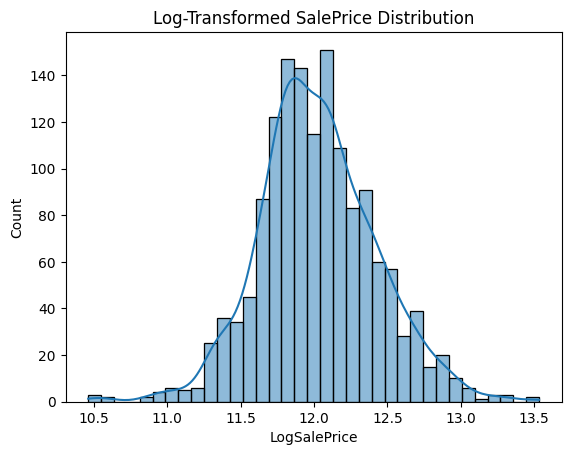

In [4]:
# Create a new column with log-transformed SalePrice to reduce skew
train_df['LogSalePrice'] = np.log(train_df['SalePrice'])

# Visualize new target distribution
sns.histplot(train_df['LogSalePrice'], kde=True)
plt.title("Log-Transformed SalePrice Distribution")
plt.show()


In [5]:
# Fill missing categorical data with "None"
cols_fill_none = ['FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                  'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
                  'MasVnrType']
for col in cols_fill_none:
    train_df[col] = train_df[col].fillna("None")

# Fill missing numerical values
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(0)
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].median())
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])


In [6]:
# Convert all categorical variables into one-hot encoded (dummy) variables
train_encoded = pd.get_dummies(train_df)

# Show new shape after encoding
print("Encoded training set shape:", train_encoded.shape)


Encoded training set shape: (1460, 301)


In [7]:
# Drop unnecessary columns
columns_to_drop = ['Id', 'SalePrice', 'LogSalePrice']
X = train_encoded.drop(columns=[col for col in columns_to_drop if col in train_encoded.columns])

# Extract the target variable (log-transformed SalePrice)
y = train_encoded['LogSalePrice'].values.reshape(-1, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1460, 298)
y shape: (1460, 1)


In [8]:
import numpy as np

# Convert DataFrame to NumPy array
X_np_clean = X.values.astype(float)

# Compute mean
mu_clean = np.mean(X_np_clean, axis=0)

# Compute std manually: std = sqrt(mean((x - mean)^2))
squared_diff = (X_np_clean - mu_clean)**2
sigma_clean = np.sqrt(np.mean(squared_diff, axis=0))

# Replace any 0 std with 1
sigma_clean[sigma_clean == 0] = 1

# Normalize the features
X_norm = (X_np_clean - mu_clean) / sigma_clean

# Add bias column
X_final = np.hstack([np.ones((X_norm.shape[0], 1)), X_norm])

# Confirm shapes
print("Final X shape:", X_final.shape)
print("y shape:", y.shape)




Final X shape: (1460, 299)
y shape: (1460, 1)


In [9]:
from sklearn.model_selection import train_test_split

# 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (1168, 299)
Validation set shape: (292, 299)


In [10]:
def compute_cost(X, y, w, lambda_):
    m = X.shape[0]
    predictions = X @ w
    error = predictions - y
    cost = (1 / (2 * m)) * np.sum(error ** 2)

    # Add L2 regularization (ignore bias term w[0])
    reg_cost = (lambda_ / (2 * m)) * np.sum(w[1:] ** 2)
    total_cost = cost + reg_cost
    return total_cost


In [11]:
def compute_gradient(X, y, w, lambda_):
    m = X.shape[0]
    predictions = X @ w
    error = predictions - y
    grad = (1 / m) * (X.T @ error)

    # Apply regularization (skip bias)
    reg = (lambda_ / m) * w
    reg[0] = 0  # Do not regularize bias term
    grad += reg
    return grad


In [12]:
def gradient_descent(X, y, w, alpha, lambda_, num_iters):
    cost_history = []

    for i in range(num_iters):
        grad = compute_gradient(X, y, w, lambda_)
        w = w - alpha * grad
        cost = compute_cost(X, y, w, lambda_)
        cost_history.append(cost)

        if i % 100 == 0 or i == num_iters - 1:
            print(f"Iteration {i:4d} | Cost: {cost:.4f}")

    return w, cost_history


In [13]:
w_init = np.zeros((X_train.shape[1], 1))
w_final, cost_history = gradient_descent(X_train, y_train, w_init, alpha=0.01, lambda_=1.0, num_iters=1000)


Iteration    0 | Cost: 70.9052
Iteration  100 | Cost: 9.4411
Iteration  200 | Cost: 1.4224
Iteration  300 | Cost: 0.2612
Iteration  400 | Cost: 0.0683
Iteration  500 | Cost: 0.0276
Iteration  600 | Cost: 0.0157
Iteration  700 | Cost: 0.0109
Iteration  800 | Cost: 0.0085
Iteration  900 | Cost: 0.0071
Iteration  999 | Cost: 0.0063


In [14]:
# Predict log-transformed values
y_pred_val_log = X_val @ w_final

# Convert back from log to actual sale prices
y_pred_val_actual = np.exp(y_pred_val_log)

# Show the first 10 predictions
print("Predicted Sale Prices (Validation Set):")
print(y_pred_val_actual[:10])


Predicted Sale Prices (Validation Set):
[[150424.63727511]
 [314496.68886379]
 [ 88780.14425023]
 [166469.20922051]
 [307308.81791431]
 [ 76198.86862142]
 [260471.66300942]
 [145000.65337719]
 [ 69837.28480136]
 [143011.53682635]]


In [15]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(np.exp(y_val), y_pred_val_actual))
print(f"Validation RMSE: ${rmse:,.2f}")


Validation RMSE: $34,752.55


In [16]:
# Handle missing values in test set
test_df.fillna({
    'FireplaceQu': 'None',
    'GarageType': 'None',
    'GarageFinish': 'None',
    'GarageQual': 'None',
    'GarageCond': 'None',
    'BsmtFinType2': 'None',
    'BsmtExposure': 'None',
    'BsmtFinType1': 'None',
    'BsmtCond': 'None',
    'BsmtQual': 'None',
    'MasVnrArea': 0,
    'GarageYrBlt': 0,
    'LotFrontage': test_df['LotFrontage'].median(),
    'Electrical': test_df['Electrical'].mode()[0]
}, inplace=True)


In [17]:
test_encoded = pd.get_dummies(test_df)


In [18]:
# Align test data to match the final training feature columns
test_aligned = test_encoded.reindex(columns=X.columns, fill_value=0)

# Recalculate mean and std from training data (X must be a DataFrame)
mu = X.mean(axis=0)
sigma = X.std(axis=0)
sigma[sigma == 0] = 1  # Avoid divide-by-zero

# Normalize test data using training mu and sigma
X_test_scaled = (test_aligned - mu) / sigma
X_test_scaled = X_test_scaled.fillna(0)  # Replace any potential NaNs

# Add intercept term AFTER scaling
X_test_scaled.insert(0, 'Intercept', 1)


/tmp/ipykernel_13/1559839498.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_scaled.insert(0, 'Intercept', 1)


In [19]:
# Predict log-transformed SalePrice using trained weights
y_pred_test_log = X_test_scaled @ w_final

# Convert log predictions back to original scale
y_pred_test_actual = np.exp(y_pred_test_log)


In [20]:
# Create submission DataFrame correctly
submission = pd.DataFrame({
    'Id': test_df['Id'],  # original test IDs
    'SalePrice': y_pred_test_actual.values.flatten()  # safely flatten
})

# Print the first 10 rows
print(submission.head(10))



     Id      SalePrice
0  1461  123381.589181
1  1462  164759.901781
2  1463  189447.915812
3  1464  200755.793319
4  1465  195435.339885
5  1466  170353.964772
6  1467  185598.493329
7  1468  167615.445669
8  1469  179102.861550
9  1470  124509.974768


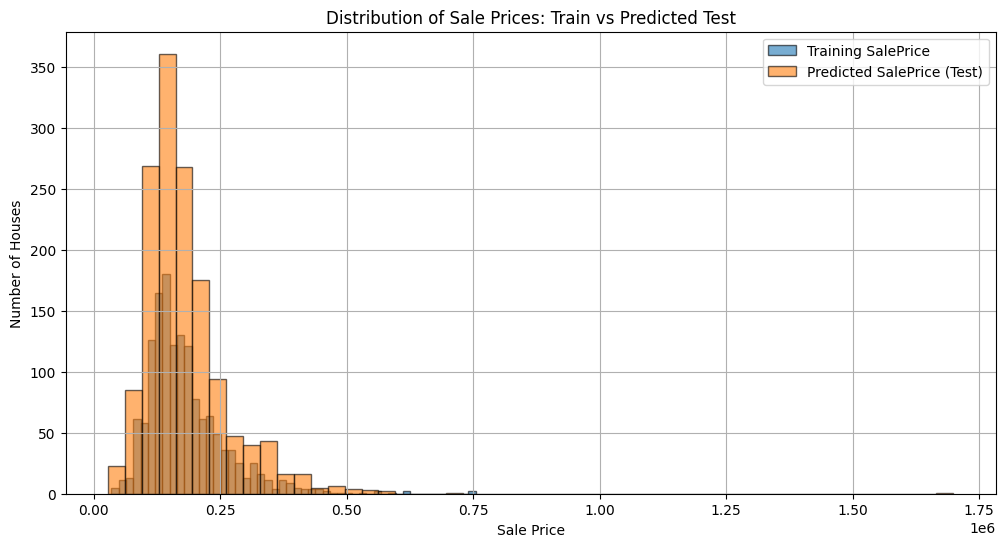

In [21]:
import matplotlib.pyplot as plt

# Recover actual SalePrice from log-transformed training target
train_sale_prices = np.exp(y)  # y is log-transformed target

plt.figure(figsize=(12, 6))
plt.hist(train_sale_prices, bins=50, alpha=0.6, label='Training SalePrice', edgecolor='k')
plt.hist(submission['SalePrice'], bins=50, alpha=0.6, label='Predicted SalePrice (Test)', edgecolor='k')
plt.title("Distribution of Sale Prices: Train vs Predicted Test")
plt.xlabel("Sale Price")
plt.ylabel("Number of Houses")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Create a submission DataFrame
submission = pd.DataFrame({
    'Id': test_df['Id'],  # Ensure 'Id' column comes from the original test dataset
    'SalePrice': y_pred_test_actual.values.flatten()  # Flatten in case it's still 2D
})

# Save the predictions to a CSV file
submission.to_csv("submission.csv", index=False)

# Confirm it's saved
print("Submission file saved as 'submission.csv'")
submission.head()


Submission file saved as 'submission.csv'


,Id,SalePrice
0,1461,123381.589181
1,1462,164759.901781
2,1463,189447.915812
3,1464,200755.793319
4,1465,195435.339885
